In [90]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path


from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *


import bokeh
from bokeh.layouts import row, column
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar, LogColorMapper, LinearColorMapper
from bokeh.transform import linear_cmap, log_cmap
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
from auctions.webutils import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
experiment = Experiment.objects.get(name='albert_games_revived_6')
# experiment = Experiment.objects.get(name='albert_games_revived_3_with_require_br')
# experiment = Experiment.objects.get(name='albert_games_revived_3_with_random_ic')

# experiment = Experiment.objects.get(name='sats_games_10_with_require_br')
# experiment = Experiment.objects.get(name='sats_games_10_with_random_ic')
experiment

<Experiment: albert_games_revived_6>

In [92]:
master_df = get_all_frames(experiment, expected_additional_br=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.44it/s]


In [85]:
len(master_df)

24

In [86]:
# !ls /shared/outputs

In [93]:
plot_all_models(master_df, notebook=True, final_compare=True)

Loading BokehJS ...

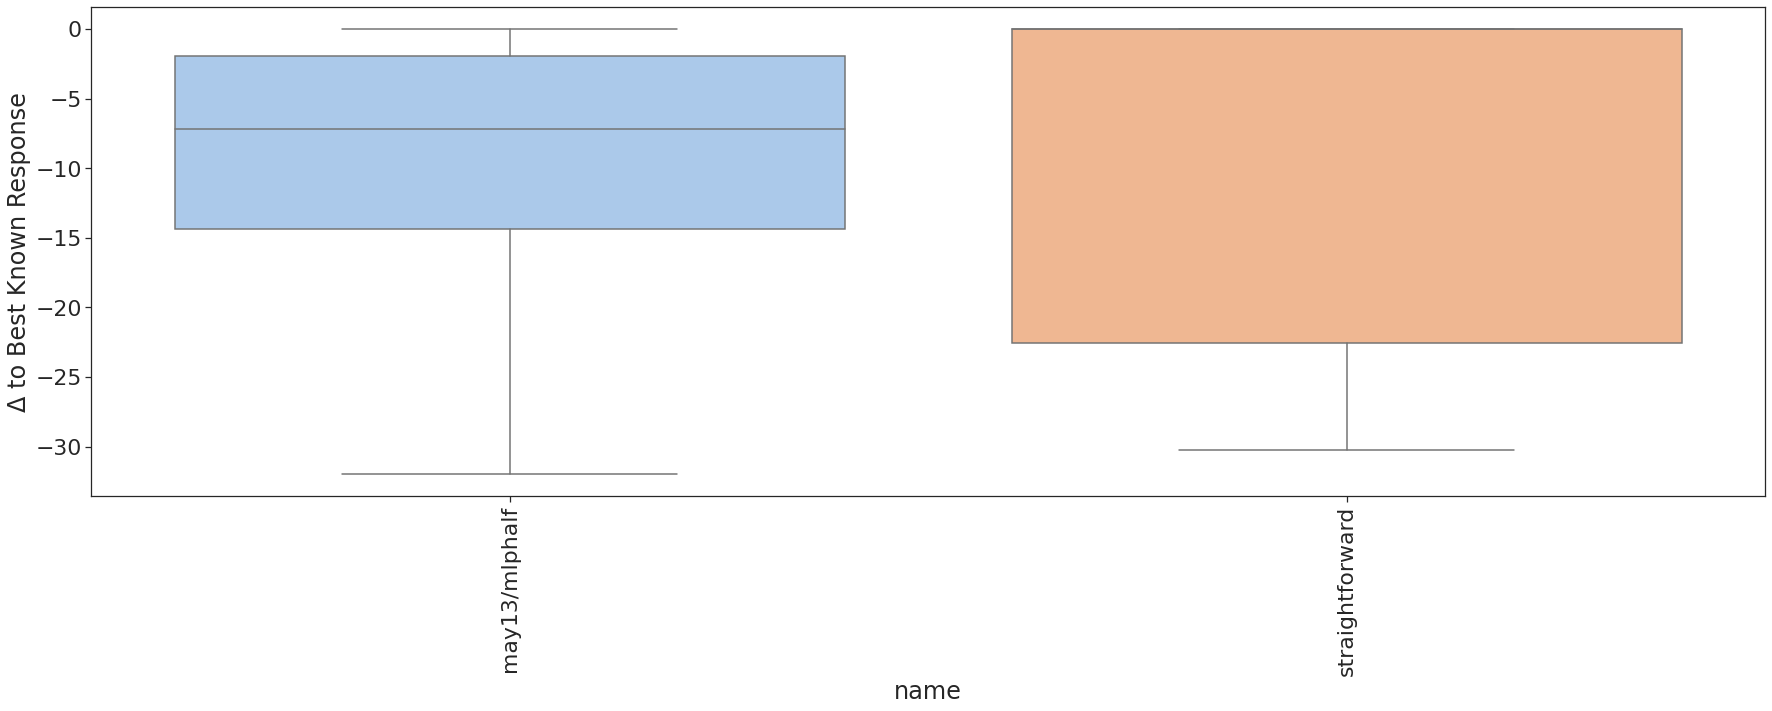

In [76]:
# s = ['_mlp', '_mlp_1', '_mlp_2', '_lstm', '_lstm_1', '_lstm_2', 'Straightforward']
# good_configs = ['straightforward', 'mar17/lstm', 'mar17/mlp-Copy6']
# fig = compare_best_responses(master_df.query('name in @good_configs'))
fig = compare_best_responses(master_df)
# special_save_fig(fig, "configs.png", fmt=None, dpi=300, tight=True)

In [ ]:
master_df.query('t == 10000000 and model == "large_game_2-flatmlpflat_handcrafted_reversed-100" and player == 1')

In [ ]:
master_df

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(15, 5))
# plt.imshow(list(q_network.output_layer.parameters())[0].data)
# plt.colorbar()

In [ ]:
master_df[['name', 'PositiveRegret']]

In [ ]:
x = master_df['name'].unique().tolist()
x.remove(None)
x.remove("straightforward")
x

In [ ]:
for config in x:
    portfolio = [config, 'straightforward']
    p = master_df.query('name in @portfolio and player == br_player').copy()
    # NOT QUITE RIGHT
    p['frac'] = p['PositiveRegret'] / p['MaxPositiveRegret']
    p = p.groupby(['model', 't', 'player']).apply(lambda x: x['frac'].max())
    print(config, p.mean())

In [ ]:
y = list(x)
y.remove('mar17/lstm')
for config in y:
    portfolio = [config, 'mar17/lstm', 'straightforward']
    p = master_df.query('name in @portfolio and player == br_player').copy()
    # NOT QUITE RIGHT
    p['frac'] = p['PositiveRegret'] / p['MaxPositiveRegret']
    p = p.groupby(['model', 't', 'player']).apply(lambda x: x['frac'].max())
    print(config, p.mean())

In [ ]:
z = list(y)
z.remove('_mlp_deep_wide')
for config in z:
    portfolio = [config, '_mlp_deep_wide', '_mlp_wide', 'Straightforward']
    p = master_df.query('config in @portfolio and player == best_responder').copy()
    # NOT QUITE RIGHT
    p['frac'] = p['PositiveRegret'] / p['MaxPositiveRegret']
    p = p.groupby(['model', 't', 'player']).apply(lambda x: x['frac'].max())
    print(config, p.mean())

In [ ]:
dir(bokeh.plotting)

In [ ]:
EquilibriumSolverRun.objects.last().pk

In [ ]:
for run in experiment.equilibriumsolverrun_set.all():
    print(run, run.walltime())

In [ ]:
# from bokeh.models import LinearAxis, Range1d

# for game_name, grp in master_df.groupby('game'):
#     for model, sub_df in grp.groupby('model'):
#         ev_df = sub_df

# ev_df = ev_df.query('name.isnull() and br_player.isnull()', engine='python').copy()
# ev_df['t'] /= 1e6 # Nicer formatting on x-axis
# game_name = ev_df['game'].iloc[0]
# model = ev_df['model'].iloc[0]
# players = range(ev_df['num_players'].iloc[0])
# title = f"Utility {game_name} {model}"
# colors = itertools.cycle(Category20_20) 
# plot = figure(width=900, height=400, title=title)
# plot.yaxis.axis_label = 'Reward'

# # Setting the second y axis range name and range
# plot.extra_y_ranges = {"rounds": Range1d(start=0, end=50)}

# # # Adding the second axis to the plot.  
# plot.add_layout(LinearAxis(y_range_name="rounds", axis_label='Temperature [°C]'), 'right')

# # add a circle renderer with a size, color, and alpha
# for p in players:
#     player_color = PLAYER_COLORS[p]

#     source = ColumnDataSource(ev_df.query(f'player == {p}')[['t', 'reward']])
#     label = f'Reward {p}'
#     plot.line('t', f'reward', source=source, legend_label=label, name=label, color=player_color)

# utility_sum = ev_df.groupby('t')['reward'].sum().to_frame('reward')
# source = ColumnDataSource(utility_sum) 
# label = f'Total Reward'
# plot.line('t', f'reward', source=source, legend_label=label, name=label, color='red', line_width=1)

# median_length = ev_df.groupby('t')['median_length'].first().to_frame('length')
# source = ColumnDataSource(median_length) 
# label = f'Median Length'
# plot.line('t', f'length', source=source, legend_label=label, name=label, color='black', line_width=1, y_range_name="rounds")


# plot.legend.click_policy = "hide"
# plot.xaxis.axis_label = 'Iteration (M)'

# TOOLTIPS = [
#     ("Name", "$name",),
#     ("(x,y)", "($x, $y)"),
# ]   
# plot.add_tools(HoverTool(tooltips=TOOLTIPS))
# show(plot)

In [23]:
x = [0, 1, 0, 0, 1]

In [27]:
np.nonzero(x)[0].tolist()

[1, 4]